# Stochastic Raytracer

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


%load_ext autoreload
%autoreload 2

### Load a scene 

We will us the utility functions to do so. Have a look at the predefined scenes.

In [2]:
from utils.scene import *
%ls ./scenes

invalid_scene_01.yaml  small01.yaml  small02.yaml  small03.yaml


These are the objects the scene contains we chose

In [3]:
scene = parse_scene('./scenes/small01.yaml')
#scene = parse_scene('./scenes/invalid_scene_01.yaml')

print([key for key in scene])

['ball_1', 'ball_2', 'ball_3', 'floor', 'wall', 'light_1', 'light_2', 'camera']


Now seperate the objects into different rendering classes

In [4]:
camera_name, camera = [ (key,scene[key]) for key in scene if type(scene[key]) is Camera ][0]
lights = { key : scene[key] for key in scene if type(scene[key]) is PointLight}
objects = { key : scene[key] for key in scene if type(scene[key]) in [Sphere, Plane]}
    
print("Camera: '%s'" % camera_name)
print('Objects: ', [key for key in objects])
print('Lights: ', [key for key in lights])

Camera: 'camera'
Objects:  ['ball_1', 'ball_2', 'ball_3', 'floor', 'wall']
Lights:  ['light_1', 'light_2']


### Shader

Phong shader utility function 

In [5]:
from utils.shader import *

In [6]:
def render(camera, objects, lights):
    
    #initial rays
    s,d = construct_initial_rays(camera)  #W,H,3
    s = s.reshape((-1,3)) #W*H,3
    d = d.reshape((-1,3))
    
    #clear screen buffers
    W,H = camera.width, camera.height 
    screen_depth = -np.ones((W,H))
    #screen_matidx = np.ones((W,H))
    screen_color = np.zeros((W,H,3))
    
    #loop over object
    for objname in objects:
        obj = objects[objname]
        
        #calculate intersections
        if type(obj) is Sphere:
            dist, normal = intersect_rays_with_sphere( (s,d), obj, return_normal=True )
        elif type(obj) is Plane:
            dist, normal = intersect_rays_with_plane( (s,d), obj, return_normal=True )
        s_new = s + dist[:,None] * d
        buffer = screen_depth.flatten()
        mask = (dist>0) & ( (buffer >= dist) | (buffer <= 1e-3) )
        
        
        color = np.zeros((W*H,3))
        
        #loop over lights
        for lightname in lights:
            light = lights[lightname] 
            
            #light ray direction
            if type(light) is PointLight:
                light_dir = s_new - light.position[None, :]
                light_dist = np.sqrt( np.sum(light_dir**2, axis=-1) + 1e-9)
                light_dir = -light_dir / light_dist[:,None]                
            
            #shadow ray
            shadow = np.zeros((W*H), dtype=bool)
            for castername in objects:
                    
                caster = objects[castername]
                    
                if type(caster) is Sphere:
                    caster_dist = intersect_rays_with_sphere( (s_new,light_dir), caster )
                elif type(caster) is Plane:
                    caster_dist = intersect_rays_with_plane( (s_new,light_dir), caster )
                
                covers = (light_dist > caster_dist) & (caster_dist > 1e-3)
                shadow = shadow | covers
                
            #run shader to get color 
            color = color + phong(d, normal, light_dir, shadow,     
                                  obj.color, obj.shininess,
                                  light.ambient, light.diffuse, light.specular) 
        
        color = np.maximum(0., np.minimum(1., color))
        
        
        # update screen
        mask = mask.reshape((W,H))
        dist = dist.reshape((W,H))
        color = color.reshape((W,H,3))
        screen_depth = np.where(mask, dist, screen_depth)
        screen_color = np.where(mask[:,:,None], color, screen_color)
        
        
    return screen_color

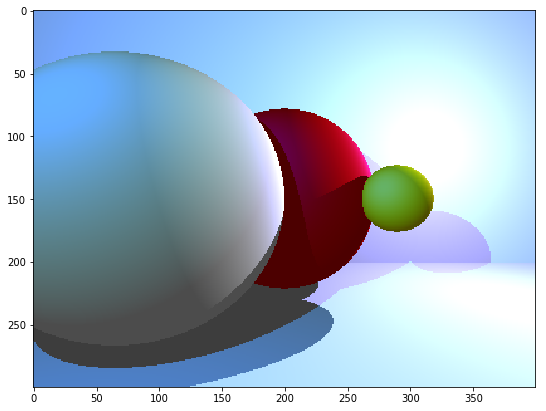

In [7]:
img = render(camera, objects, lights)
plt.figure(figsize=(9,7))

#plt.imshow(img.transpose(), cmap='gray', vmin=0., vmax=30.)
plt.imshow(img[:,::-1,:].transpose((1,0,2)))

plt.show()

### Stochastic Beam

We will assume the beam consists of Gaussianly distributed rays. To be precise the angular deviation is Gaussianly distributed. Depicting the standard deviation of the distribution as in the image below the beam is shaped like a cone

![stochastic beam](./images/stochastic_beam.png)


To sample rays from this Gaussian distibution let us write an auxiliary function 

In [15]:

import utils.torchify as t

In [16]:

def sample_angular_dispersion(directions, n_samples=10, angular_std=None):
    assert len(directions.shape) == 2 and directions.shape[1] == 3, \
        'Directional vectors should have shape (N,3)'
    N = directions.shape[0]
    
    if angular_std is None: angular_std = np.deg2rad(5.0)
    angular_std = t.astensor(angular_std)
    if len(angular_std.shape)==0 or angular_std.shape==(1,): 
        angular_std = t.repeat(angular_std, N, axis=0)
        
    assert len(angular_std.shape) == 1 and angular_std.shape[0] == N, \
        'Angular standards should have same number of elements as directional vectors.'
    
    #sample rotation axis uniformly from sphere via rejection sampling
    attempts = 100
    correct_samples = t.zeros((N, n_samples), dtype=bool)
    rotation_axis = t.random_normal(size=(N,n_samples,3))
    for _ in range(attempts): #attempt to sample from normal distribution without getting zero 
        print('Angular dispersion sampling attempt number ', _)
        sampled_rotation_axis = t.random_normal(size=(N,n_samples,3))
        sampled_rotation_axis = t.where(correct_samples[:,:,None], rotation_axis, sampled_rotation_axis)   
        new_correct_samples = t.sum(sampled_rotation_axis**2, axis=-1) > 1e-3
        if t.all( new_correct_samples ): break
        correct_samples = new_correct_samples
    if _ == attempts-1: print('All samples rejected! Run again.') # doesn't happen in practise!
    rotation_axis = rotation_axis / t.sqrt( t.sum(rotation_axis**2, axis=-1) )[:,:,None]
        
    #sample angle from normal distribution 
    angles = t.random_normal(scale=angular_std[:,None], size=(N,n_samples))
    
    #rotate directional vector according to Rodrigues' rotation formula
    d_new = t.cos(angles)[:,:,None] * directions[:,None,:] 
    d_new = d_new + t.sin(angles)[:,:,None] * t.cross(rotation_axis, directions[:,None,:]) 
    d_new = d_new + (1-t.cos(angles))[:,:,None] * rotation_axis * \
        t.sum(rotation_axis * directions[:,None,:], axis=-1)[:,:,None] 
    
    return d_new

In [17]:
#Unit test
rays = t.tensor([[1,0,0]])
rays = sample_angular_dispersion(rays, 1000, np.deg2rad(5.))
rays = rays[0,:,:]
                                
fig = plt.figure(figsize=(8,9))
ax = plt.axes(projection='3d')

x,y,z = rays[:,0],rays[:,1],rays[:,2]
ax.scatter(x, y, z, c='r', marker='^', alpha=.1)

N = rays.shape[0]
for r in range(N):
    plt.plot([0,x[r]],[0,y[r]],[0,z[r]], color='r', alpha=.1)

plt.show()

IndexError: dimension specified as 0 but tensor has no dimensions

Reimplement the rendering routines, this time with an additional axis for the samples. 

In [10]:
def render(camera, objects, lights):
    
    #initial rays
    s,d = construct_initial_rays(camera) #W,H,3
    s = s.reshape((-1,3)) #W*H,3
    d = d.reshape((-1,3))
    n_samples = 10
    d = sample_angular_dispersion(d, n_samples) #W*H,N,3
    s = t.repeat( s[:,None,:], n_samples, axis=1 )
    s = s.reshape((-1,3)) #W*H*N,3
    d = d.reshape((-1,3))
    print('s:', s.shape)
    print('d:', d.shape)
    #print(':', )
    
    #clear screen buffers
    W,H = camera.width, camera.height 
    screen_depth = -t.ones((W,H))
    #screen_matidx = np.ones((W,H))
    screen_color = t.zeros((W,H,3))
    sample_buffer = -t.ones(W*H*n_samples)

    #loop over object
    for objname in objects:
        obj = objects[objname]
        
        #calculate intersections
        if type(obj) is Sphere:
            dist, normal = intersect_rays_with_sphere( (s,d), obj, return_normal=True )
        elif type(obj) is Plane:
            dist, normal = intersect_rays_with_plane( (s,d), obj, return_normal=True )
        s_new = s + dist[:,None] * d
        buffer = screen_depth.flatten()
        mask = (dist>0) & ( (sample_buffer >= dist) | (sample_buffer <= 1e-3) )
        sample_buffer = t.where(mask, dist, sample_buffer)
        
        
        color = t.zeros((W*H*n_samples,3))
        
        #loop over lights
        for lightname in lights:
            light = lights[lightname] 
            
            #light ray direction
            if type(light) is PointLight:
                light_dir = s_new - light.position[None, :]
                light_dist = t.sqrt( t.sum(light_dir**2, axis=-1) + 1e-9)
                light_dir = -light_dir / light_dist[:,None]                
            
            #shadow ray
            shadow = t.zeros((W*H*n_samples), dtype=bool)
            for castername in objects:
                    
                caster = objects[castername]
                    
                if type(caster) is Sphere:
                    caster_dist = intersect_rays_with_sphere( (s_new,light_dir), caster )
                elif type(caster) is Plane:
                    caster_dist = intersect_rays_with_plane( (s_new,light_dir), caster )
                
                covers = (light_dist > caster_dist) & (caster_dist > 1e-3)
                shadow = shadow | covers
                
            #run shader to get color 
            color = color + phong(d, normal, light_dir, shadow,     
                                  obj.color, obj.shininess,
                                  light.ambient, light.diffuse, light.specular) 
        
        color = t.maximum(0., t.minimum(1., color))
        
        #aggregate over samples
        sample_mask = mask.reshape((W,H,-1))
        pixel_mask = t.any(sample_mask, axis=-1)
        dist = dist.reshape((W,H,-1))
        dist = t.sum( sample_mask * dist, )
        dist = t.where( pixel_mask, dist / (t.sum(sample_mask, axis=2) + 1e-9), -1)
        color = color.reshape((W,H,-1,3))
        color = t.sum(sample_mask[:,:,:,None]*color, axis=2)
        color = t.where(pixel_mask[:,:,None], color / (t.sum(sample_mask, axis=2) + 1e-9)[:,:,None], -1)
        
        # update screen
        screen_depth = t.where(pixel_mask, dist, screen_depth)
        screen_color = t.where(pixel_mask[:,:,None], color, screen_color)
        
        
    return screen_color

Angular dispersion sampling attempt number  0
Angular dispersion sampling attempt number  1
Angular dispersion sampling attempt number  2
s: (1200000, 3)
d: (1200000, 3)


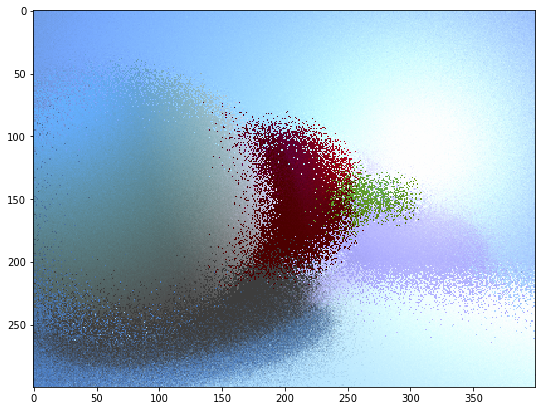

In [11]:
img = render(camera, objects, lights)
plt.figure(figsize=(9,7))

#plt.imshow(img.transpose(), cmap='gray', vmin=0., vmax=30.)
plt.imshow(img[:,::-1,:].transpose((1,0,2)))

plt.show()

### Fresnel Shader

Using Fresnel's equations reflections and refractions can be modeled quite well using an iterative approach. Assuming that light sometimes passes through an object and others is reflected gives us a stochastic renderer. We want to know the expected pixel color that results from randomly either reflecting or reflecting light rays at any collision. 

![bouncing](./images/rendering_iterations.png)


A rendering iteration basically bounces light rays from an object to the next. The total number of iterations will be fixed and rather small. If caustics and other artifacts are desired photon mapping can be employed additionally but let us keep it simple for now. 
